In [ ]:
import tensorflow as tf
import os
import random
import numpy as np
import cv2
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.util import random_noise

from keras import layers, metrics

from skimage.measure import label, regionprops, regionprops_table

In [ ]:
IMAGE_CHANNELS = 3

IMAGE_HEIGHT =  192 
IMAGE_WIDTH = 64

In [ ]:
seed = 4
np.random.seed = seed
random.seed(seed)

DATA_TRAIN = "./datasets/KolektorSDD2/train/"
DATA_TEST = "./datasets/KolektorSDD2/test/"

train_ids = next(os.walk(os.path.join(DATA_TRAIN, "images/")))[2]
test_ids = next(os.walk(os.path.join(DATA_TEST, "images/")))[2]

damaged = []
damaged_mask = []
X_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
y_train = np.zeros((len(train_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = DATA_TRAIN 

    img = imread(path + 'images/' + id_)[:,:,:IMAGE_CHANNELS]  
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    X_train[n] = img  # Fill empty X_train with values from img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]
    
    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = mask.astype(np.bool_) 
    mask = mask.astype(np.float16)  
    y_train[n] = mask 

    if np.count_nonzero(mask) != 0:
        damaged.append(img)
        damaged_mask.append(mask)

# test images
test_images = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float16)
test_masks = np.zeros((len(test_ids), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float16)

sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = DATA_TEST
    img = imread(path + '/images/' + id_ )[:,:,:IMAGE_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    img /= 255.0
    test_images[n] = img

    mask = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=bool)
    mask_file = os.path.join(path + 'masks/' + id_[:5] + "_GT.png")
    mask = imread(mask_file)[:,:]

    mask = resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH), mode='constant', preserve_range=True)
    mask /= 255.0     
    mask = mask.astype(np.bool_) 
    mask = mask.astype(np.float16)  
    test_masks[n] = mask 

print('Done!')

Resizing training images and masks


  0%|          | 0/2332 [00:00<?, ?it/s]

100%|██████████| 2332/2332 [01:18<00:00, 29.73it/s]


Resizing test images


100%|██████████| 1004/1004 [00:32<00:00, 30.45it/s]

Done!


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

print("Percentage of faulty images in train data:", counts[1]/(counts[0]+counts[1])*100, " %")
neg = counts[0]
pos = counts[1]

1254765
{0.0: 54459027, 1.0: 1254765}
Percentage of faulty images in train data: 2.252162265314843  %


Bounding Box

In [ ]:
Boxes = []
check = []
for img in damaged_mask:
    labels = label(img)
    regions = regionprops(labels)
    if len(regions) == 1:
        check.append(1)
        for props in regions:
            min_x, min_y, max_x, max_y = props.bbox
            Boxes.append((min_x, min_y, max_x, max_y))
    else:
        check.append(0)

In [ ]:
# Throw out images, which have more than one damage
onedamage = [damaged[i] for i in range(len(damaged)) if check[i] == 1]
onedamage_mask = [damaged_mask[i] for i in range(len(damaged_mask)) if check[i] == 1]

In [ ]:
def crop_image(image, bbox):
    # Crop the image using NumPy array slicing
    cropped_image = image[bbox[0]:bbox[2], bbox[1]:bbox[3]]
    return cropped_image

def overlay_image(background, background_mask, overlay, overlay_mask):
    # Generate random position for overlay image
    if overlay.shape[1] < background.shape[1]:
        x_offset = np.random.randint(0, background.shape[1] - overlay.shape[1])
        y_offset = np.random.randint(0, background.shape[0] - overlay.shape[0])
    
         # Overlay the image
        background[y_offset:y_offset + overlay.shape[0], x_offset:x_offset + overlay.shape[1]] = overlay
        background_mask[y_offset:y_offset + overlay_mask.shape[0], x_offset:x_offset + overlay_mask.shape[1]] = overlay_mask
        return background, background_mask
    else:
        return background, background_mask

generated_img = np.empty((226,192,64,3))
generated_mask = np.empty((226, 192,64))
overlayed_indices = []
for i, image in enumerate(onedamage):
    # Get the bounding box for the current image
    bbox = Boxes[i]
    mask = onedamage_mask[i]
    # Crop the image
    cropped_image = crop_image(image, bbox)
    cropped_mask = crop_image(mask, bbox)
    # Pick a random overlay image from the list
    overlay_image_index = np.random.choice([idx for idx in range(len(X_train)) if idx not in overlayed_indices])
    overlay = X_train[overlay_image_index]
    overlay_mask = y_train[overlay_image_index]

    # Overlay the cropped image onto the random overlay image
    new_image, new_mask = overlay_image(overlay, overlay_mask, cropped_image, cropped_mask)
    generated_img[i] = new_image
    generated_mask[i] = new_mask
    overlayed_indices.append(overlay_image_index)


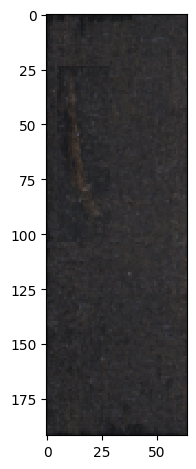

In [ ]:
imshow(generated_img[14])
plt.show()

Augmentation

In [ ]:
vertical_train = np.flip(damaged, axis=0)
vertical_test = np.flip(damaged_mask, axis=0)

horizontal_train = np.flip(damaged, axis=1)
horizontal_test = np.flip(damaged_mask, axis=1)

rotating_train = np.rot90(damaged, k=2)
rotating_test = np.rot90(damaged_mask, k=2)

vert_rot_train = np.rot90(vertical_train, k=2)
vert_rot_test = np.rot90(vertical_test, k=2)

hor_rot_train = np.rot90(horizontal_train, k=2)
hor_rot_test = np.rot90(horizontal_test, k=2)

Add Noise

In [ ]:
noised = np.empty_like(damaged)
noised_mask = damaged_mask
for img in damaged:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised[i] = noise
    i = i+1

noised_vert = np.empty_like(damaged)
noised_mask_vert = vertical_test
for img in vertical_train:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_vert[i] = noise
    i = i+1

noised_horr = np.empty_like(damaged)
noised_mask_horr = horizontal_test
for img in horizontal_train:
    i = 0
    noise = random_noise(img, mode='gaussian', rng=seed, clip=True)
    noised_horr[i] = noise
    i = i+1

In [ ]:
print(np.shape(damaged))
print(np.shape(noised))

(247, 192, 64, 3)
(247, 192, 64, 3)


In [ ]:
X_train = np.concatenate((vertical_train, horizontal_train, rotating_train, vert_rot_train, hor_rot_train, X_train, noised, noised_vert, noised_horr, generated_img))
y_train = np.concatenate((vertical_test, horizontal_test, rotating_test, vert_rot_test, hor_rot_test, y_train, noised_mask, noised_mask_vert, noised_mask_horr, generated_mask))

In [ ]:
print(X_train.shape)

(4534, 192, 64, 3)
